In [1]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [2]:
import pandas as pd

train = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_train.csv")
test = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_test.csv")
cus = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/cus_info.csv")
iem = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/iem_info_20210902.csv")
hist = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_bnc_hist.csv")
submission = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/sample_submission.csv")

In [3]:
train.head(3)

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5


In [4]:
test.head(3)

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0


In [5]:
train["hist_d"] = train["hold_d"]*0.877
train.hist_d = np.trunc(train["hist_d"])

In [6]:
train

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,9.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,70.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,4.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,19.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,284.0
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,0.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,0.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,0.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,0.0


In [7]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [8]:
train_data.shape

(681472, 18)

In [9]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [10]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [11]:
train_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0


In [12]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,19.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,284.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [13]:
test_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0


In [14]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

## 딥러닝

In [15]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [16]:
train_data.shape

(681472, 18)

In [17]:
train_label.shape

(681472,)

In [18]:
train_label = train_label.values.reshape((-1,1))

In [19]:
train_label.shape

(681472, 1)

In [20]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(train_data, train_label, test_size=0.2, random_state=34)

In [21]:
# print(train_x.shape)
# print(train_y.shape)
# print(val_x.shape)
# print(val_y.shape)

In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16,input_shape=[18], activation='relu'),
        layers.Dense(8,input_shape=[16], activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','accuracy'])
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [24]:
EPOCHS = 300
history = model.fit(train_data, train_label, epochs=EPOCHS, validation_split=0.2, verbose=1)
history

Epoch 1/300
17037/17037 [==============================] - 15s 818us/step - loss: 670853706524.2174 - mae: 53962.9019 - accuracy: 0.1544 - val_loss: 505692.2500 - val_mae: 146.5189 - val_accuracy: 0.2180
Epoch 2/300
17037/17037 [==============================] - 12s 701us/step - loss: 14255374180.2951 - mae: 7872.2646 - accuracy: 0.1614 - val_loss: 19372882.0000 - val_mae: 1801.4613 - val_accuracy: 0.2556
Epoch 3/300
17037/17037 [==============================] - 12s 728us/step - loss: 3216547525.7214 - mae: 6274.3349 - accuracy: 0.1332 - val_loss: 731192.0625 - val_mae: 477.5125 - val_accuracy: 0.0097
Epoch 4/300
17037/17037 [==============================] - 12s 696us/step - loss: 2330761463.5112 - mae: 4131.1704 - accuracy: 0.1117 - val_loss: 710.9485 - val_mae: 10.2366 - val_accuracy: 0.2726
Epoch 5/300
17037/17037 [==============================] - 15s 904us/step - loss: 492597.7022 - mae: 27.2248 - accuracy: 0.2798 - val_loss: 27010.5723 - val_mae: 100.8625 - val_accuracy: 0.2726

17037/17037 [==============================] - 16s 925us/step - loss: 4566.1003 - mae: 8.4613 - accuracy: 0.2802 - val_loss: 54.4163 - val_mae: 3.9404 - val_accuracy: 0.2726
Epoch 45/300
17037/17037 [==============================] - 15s 858us/step - loss: 8125.5065 - mae: 8.7477 - accuracy: 0.2806 - val_loss: 127.3555 - val_mae: 4.9260 - val_accuracy: 0.2726
Epoch 46/300
17037/17037 [==============================] - 14s 830us/step - loss: 1387.4067 - mae: 7.7763 - accuracy: 0.2803 - val_loss: 70.6388 - val_mae: 4.5965 - val_accuracy: 0.2726
Epoch 47/300
17037/17037 [==============================] - 15s 880us/step - loss: 1124.6008 - mae: 7.7796 - accuracy: 0.2803 - val_loss: 206.6014 - val_mae: 7.3359 - val_accuracy: 0.2726
Epoch 48/300
17037/17037 [==============================] - 15s 892us/step - loss: 2761.1843 - mae: 7.9623 - accuracy: 0.2798 - val_loss: 145.5305 - val_mae: 3.7759 - val_accuracy: 0.2726
Epoch 49/300
17037/17037 [==============================] - 15s 888us/step 

Epoch 88/300
17037/17037 [==============================] - 13s 786us/step - loss: 1294.2232 - mae: 6.0225 - accuracy: 0.2806 - val_loss: 9.6635 - val_mae: 2.3223 - val_accuracy: 0.2726
Epoch 89/300
17037/17037 [==============================] - 13s 750us/step - loss: 421.7166 - mae: 5.2539 - accuracy: 0.2807 - val_loss: 23.4608 - val_mae: 2.5845 - val_accuracy: 0.2726
Epoch 90/300
17037/17037 [==============================] - 13s 736us/step - loss: 2866.7457 - mae: 5.6953 - accuracy: 0.2801 - val_loss: 288.0898 - val_mae: 8.5592 - val_accuracy: 0.2726
Epoch 91/300
17037/17037 [==============================] - 16s 924us/step - loss: 509.7525 - mae: 5.2165 - accuracy: 0.2802 - val_loss: 15.0195 - val_mae: 2.3273 - val_accuracy: 0.2726
Epoch 92/300
17037/17037 [==============================] - 15s 853us/step - loss: 528.5114 - mae: 5.5725 - accuracy: 0.2802 - val_loss: 52.4752 - val_mae: 4.5069 - val_accuracy: 0.2726
Epoch 93/300
17037/17037 [==============================] - 16s 964u

Epoch 132/300
17037/17037 [==============================] - 15s 883us/step - loss: 360.8944 - mae: 4.2473 - accuracy: 0.2811 - val_loss: 33.8303 - val_mae: 3.0359 - val_accuracy: 0.2726
Epoch 133/300
17037/17037 [==============================] - 13s 771us/step - loss: 335.9479 - mae: 4.0972 - accuracy: 0.2807 - val_loss: 4.3939 - val_mae: 1.2536 - val_accuracy: 0.2726
Epoch 134/300
17037/17037 [==============================] - 15s 877us/step - loss: 296.4145 - mae: 4.1442 - accuracy: 0.2803 - val_loss: 8.3710 - val_mae: 1.9215 - val_accuracy: 0.2726
Epoch 135/300
17037/17037 [==============================] - 11s 622us/step - loss: 260.0613 - mae: 4.2994 - accuracy: 0.2799 - val_loss: 36.9361 - val_mae: 2.9965 - val_accuracy: 0.2726
Epoch 136/300
17037/17037 [==============================] - 14s 848us/step - loss: 1030.8251 - mae: 4.1851 - accuracy: 0.2803 - val_loss: 58.9560 - val_mae: 3.6581 - val_accuracy: 0.2726
Epoch 137/300
17037/17037 [==============================] - 14s 8

Epoch 176/300
17037/17037 [==============================] - 14s 819us/step - loss: 192.7649 - mae: 3.4043 - accuracy: 0.2809 - val_loss: 2.7825 - val_mae: 0.8655 - val_accuracy: 0.2726
Epoch 177/300
17037/17037 [==============================] - 9s 501us/step - loss: 191.2357 - mae: 3.3285 - accuracy: 0.2793 - val_loss: 9.6655 - val_mae: 1.2994 - val_accuracy: 0.2726
Epoch 178/300
17037/17037 [==============================] - 8s 470us/step - loss: 274.2740 - mae: 3.3160 - accuracy: 0.2812 - val_loss: 28.6500 - val_mae: 3.2618 - val_accuracy: 0.2726
Epoch 179/300
17037/17037 [==============================] - 8s 457us/step - loss: 404.8595 - mae: 3.3503 - accuracy: 0.2796 - val_loss: 28.1053 - val_mae: 2.3115 - val_accuracy: 0.2726
Epoch 180/300
17037/17037 [==============================] - 8s 484us/step - loss: 152.8203 - mae: 3.2618 - accuracy: 0.2798 - val_loss: 51.9575 - val_mae: 3.6792 - val_accuracy: 0.2726
Epoch 181/300
17037/17037 [==============================] - 8s 462us/s

17037/17037 [==============================] - 8s 478us/step - loss: 277.0583 - mae: 2.9902 - accuracy: 0.2806 - val_loss: 24.3333 - val_mae: 2.5405 - val_accuracy: 0.2726
Epoch 221/300
17037/17037 [==============================] - 8s 482us/step - loss: 298.7797 - mae: 3.1433 - accuracy: 0.2817 - val_loss: 1.4432 - val_mae: 0.8432 - val_accuracy: 0.2726
Epoch 222/300
17037/17037 [==============================] - 8s 487us/step - loss: 227.1649 - mae: 3.2169 - accuracy: 0.2806 - val_loss: 7.1633 - val_mae: 1.5938 - val_accuracy: 0.2726
Epoch 223/300
17037/17037 [==============================] - 8s 483us/step - loss: 155.7723 - mae: 3.1173 - accuracy: 0.2799 - val_loss: 26.2230 - val_mae: 2.6908 - val_accuracy: 0.2726
Epoch 224/300
17037/17037 [==============================] - 8s 480us/step - loss: 159.5676 - mae: 3.1708 - accuracy: 0.2803 - val_loss: 6.6241 - val_mae: 1.4159 - val_accuracy: 0.2628
Epoch 225/300
17037/17037 [==============================] - 8s 479us/step - loss: 162.

17037/17037 [==============================] - 8s 485us/step - loss: 121.4559 - mae: 2.9505 - accuracy: 0.2796 - val_loss: 22.5573 - val_mae: 1.9142 - val_accuracy: 0.2726
Epoch 265/300
17037/17037 [==============================] - 8s 480us/step - loss: 137.9383 - mae: 2.9446 - accuracy: 0.2787 - val_loss: 1.0349 - val_mae: 0.5017 - val_accuracy: 0.2726
Epoch 266/300
17037/17037 [==============================] - 8s 497us/step - loss: 162.8977 - mae: 2.9308 - accuracy: 0.2796 - val_loss: 39.6327 - val_mae: 2.9034 - val_accuracy: 0.2726
Epoch 267/300
17037/17037 [==============================] - 8s 488us/step - loss: 191.6948 - mae: 2.9069 - accuracy: 0.2792 - val_loss: 22.6483 - val_mae: 2.2243 - val_accuracy: 0.2726
Epoch 268/300
17037/17037 [==============================] - 8s 492us/step - loss: 104.2853 - mae: 2.8499 - accuracy: 0.2804 - val_loss: 16.9358 - val_mae: 1.8575 - val_accuracy: 0.2726
Epoch 269/300
17037/17037 [==============================] - 8s 474us/step - loss: 14

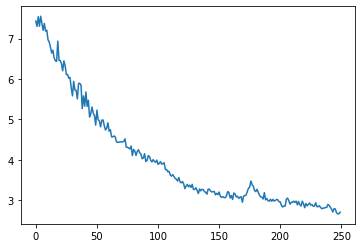

In [26]:
plt.plot(history.history['mae'][50:])

In [27]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

NameError: name 'models' is not defined

In [30]:
test_data.shape

(70596, 18)

In [31]:
submission["hold_d"] = model.predict(test_data)

In [36]:
submission["hold_d"] = np.round(submission["hold_d"]).astype('int')

In [38]:
submission

,submit_id,hold_d
0,IDX00001,172
1,IDX00002,379
2,IDX00003,156
3,IDX00004,264
4,IDX00005,11
...,...,...
70591,IDX70592,29
70592,IDX70593,118
70593,IDX70594,989
70594,IDX70595,12


In [39]:
submission.to_csv("20211010_dnn1.csv", index = False)

## 83.8147